# Common grid bias-adjustment quality control

Quality control the bias-adjusted common grid data!

In [2]:
# parameters cell
working_dir = "/import/beegfs/CMIP6/crstephenson"
sim_dir = "/import/beegfs/CMIP6/arctic-cmip6/regrid"
adj_dir = "/import/beegfs/CMIP6/crstephenson/bias_adjust/netcdf"
ref_dir = "/import/beegfs/CMIP6/arctic-cmip6/era5/daily_regrid"

In [2]:
from datetime import datetime
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import dask
from dask_jobqueue import SLURMCluster
from config import *
from bias_adjust import generate_cmip6_fp
from generate_doy_summaries import get_sim_fps
from slurm import get_directories
from luts import sim_ref_var_lu

combo_string = f"{var_id}_{model}_{scenario}"

# Each Slurm job gets its own Dask tmp directory to avoid clobbering.
tmp_dir = f"/beegfs/CMIP6/crstephenson/tmp/{combo_string}"

# Create Dask tmp_dir if it doesn't exist.
if not Path(tmp_dir).exists():
    Path(tmp_dir).mkdir()

dask.config.set(temporary_directory=tmp_dir)
dask.config.set({"array.chunk-size": "64 MB"})

working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)
cmip6_tmp_fn = "{var_id}_day_{model}_{scenario}_adjusted_{year}0101-{year}1231.nc"

output_dir, adj_dir = get_directories(working_dir, output_dir_name)
log_dir = "."

# Years for ERA5 reference data
ref_years = list(range(1981, 2022 + 1))

# Years for CMIP6 data
if scenario == "historical":
    model_years = list(range(1951, 2014 + 1))
else:
    model_years = list(range(2015, 2100 + 1))

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from config import *


working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)
doy_summary_dir = working_dir.joinpath(
    output_dir_name, qc_dir_name, doy_summary_dir_name
)

## Verify long term day-of-year summaries

Compare the day-of-year (DOY) values between reference data, unadjusted model data, and adjusted model data. 

We have computed DOY summaries for these data which consist of minimum, mean, and maximum values taken over all years.
There are many possible ways to analyze these summaries to assess the quality of the adjusted data. 

* Entire datasets can be compared using simple deltas and subequent summaries thereof, and with distance metrics like RMSE 
* pixel DOY "time" series can be assessed using line charts

The minimum and maximum differences (deltas) between DOY summary statistics of adjusted and unadjusted data can help us identify extremes / over-corrections. For example, we can evaluate the largest adjustments for each pixel by computing the maximum deltas between adjusted and unadjusted data DOY maximums, and the minimum deltas between DOY minimums. Means of these corresponding deltas show us the average adjustments at the extremes.

Open the DOY summaries for the historical precip simulations of a single model:

In [7]:
ds = xr.open_mfdataset(
    list(doy_summary_dir.glob(f"{combo_string}_*.nc"))
).squeeze()

ds

<xarray.Dataset>
Dimensions:    (lat: 43, lon: 288, dayofyear: 365, kind: 2)
Coordinates:
  * lat        (lat) float64 50.42 51.36 52.3 53.25 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * kind       (kind) object 'adj' 'sim'
    scenario   <U10 'historical'
    var_id     <U2 'pr'
    model      <U13 'CNRM-CM6-1-HR'
Data variables:
    min        (kind, dayofyear, lat, lon) float64 dask.array<chunksize=(1, 365, 43, 288), meta=np.ndarray>
    mean       (kind, dayofyear, lat, lon) float64 dask.array<chunksize=(1, 365, 43, 288), meta=np.ndarray>
    max        (kind, dayofyear, lat, lon) float64 dask.array<chunksize=(1, 365, 43, 288), meta=np.ndarray>

In [9]:
from xclim import units

ds["mean"].attrs["units"] = ds["max"].attrs["units"] = ds["min"].attrs["units"] = ""

delta_ds = ds.sel(kind="adj") - ds.sel(kind="sim")


temp_ds = delta_ds.min(dim="dayofyear")["min"]

# Double check that this is right vs. the files we're reading, or if this is needed.
temp_ds.attrs["units"] = "mm / d"

units.convert_units_to(temp_ds, "mm / d")

KeyError: 'units'

Generate maps of these summaries:

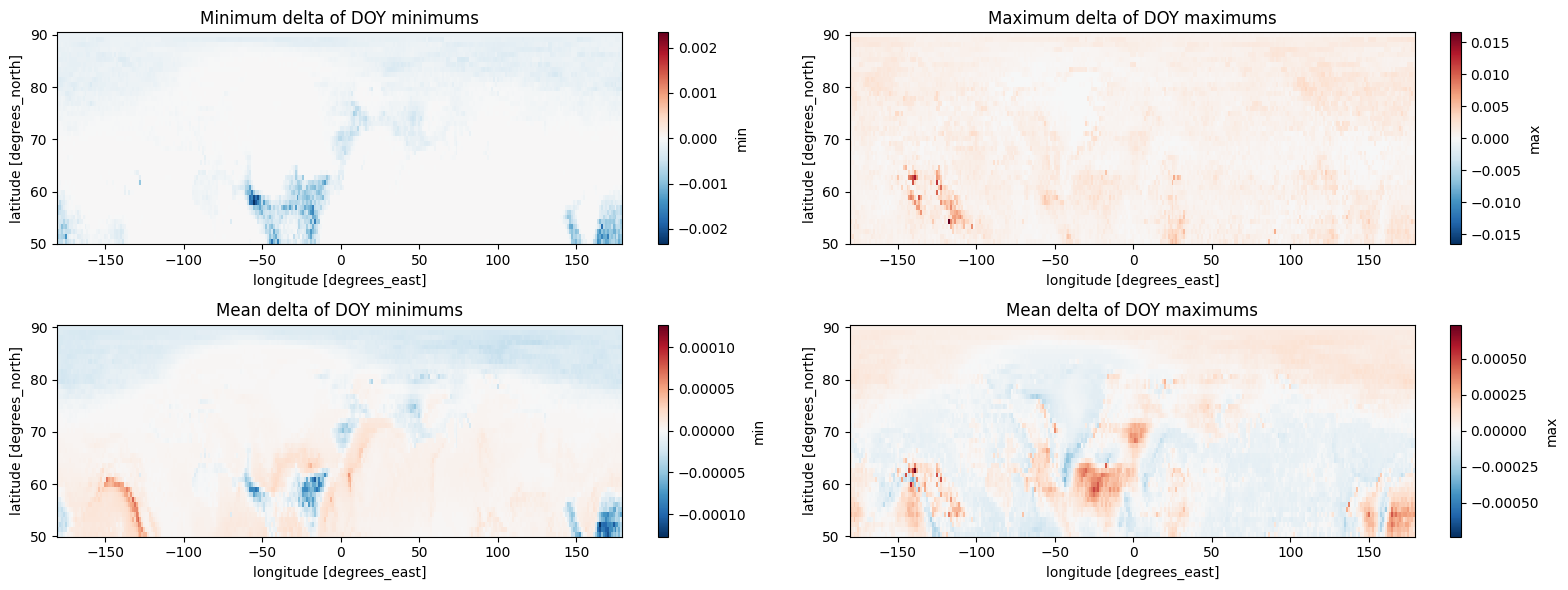

In [6]:
delta_ds = ds.sel(kind="adj") - ds.sel(kind="sim")
fig, ax = plt.subplots(2, 2, figsize=(16, 6))

delta_ds.min(dim="dayofyear")["min"].plot(ax=ax[0][0])
ax[0][0].set_title("Minimum delta of DOY minimums")
delta_ds.max(dim="dayofyear")["max"].plot(ax=ax[0][1])
ax[0][1].set_title("Maximum delta of DOY maximums")
delta_ds.mean(dim="dayofyear")["min"].plot(ax=ax[1][0])
ax[1][0].set_title("Mean delta of DOY minimums")
delta_ds.mean(dim="dayofyear")["max"].plot(ax=ax[1][1])
ax[1][1].set_title("Mean delta of DOY maximums")

plt.tight_layout()

We can draw the following conclusions:

* The largest within-day-of-year difference in precipitation between adjusted and unadjusted data is ~1.5 m! That is, there is some value in the adjusted data that is ~1.5 m larger than some value in the unadjusted data for the same day-of-year. (max difference between day-of-year maximums)
* The smallest within-day-of-year difference in precipitation between adjusted and unadjusted data is about -0.2 m (i.e. min difference between day-of-year minimums)
* mean difference between day-of-year minimums is ~0.01 m
* mean difference between day-of-year maximums is ~0.1 m

This plot seems like a good start for plotting for each subdataset. Make a function and iterate to plot:

In [56]:
def doy_summary_plot(ds):
    delta_ds = ds.sel(kind="adj") - ds.sel(kind="sim")
    fig, ax = plt.subplots(2, 2, figsize=(16, 6))

    delta_ds.min(dim="dayofyear")["min"].plot(ax=ax[0][0])
    ax[0][0].set_title("Minimum delta of DOY minimums")
    delta_ds.max(dim="dayofyear")["max"].plot(ax=ax[0][1])
    ax[0][1].set_title("Maximum delta of DOY maximums")
    delta_ds.mean(dim="dayofyear")["min"].plot(ax=ax[1][0])
    ax[1][0].set_title("Mean delta of DOY minimums")
    delta_ds.mean(dim="dayofyear")["max"].plot(ax=ax[1][1])
    ax[1][1].set_title("Mean delta of DOY maximums")

    fig.suptitle(
        f"Variable: {ds.var_id.values}, Model: {ds.model.values}, Scenario: {ds.scenario.values}"
    )

    plt.tight_layout()

What we are trying to get after is adjustments that have gone too far. An example of this is mean adjusted DOY dataset being 20-30x larger than modeled data.

For each model, scenario, variable, and day-of-year summary statistic (min, mean, max) we can evaluate the differences between modeled and adjusted data. 

In [1]:
ds = xr.open_mfdataset(
    list(doy_summary_dir.glob(f"{combo_string}_*.nc"))
).squeeze()
delta_ds = ds.sel(kind="adj") - ds.sel(kind="sim")

NameError: name 'xr' is not defined

In [25]:
maximum_doy_deltas = delta_ds["mean"].max(dim="dayofyear").compute()
tmp = maximum_doy_deltas.where(
    maximum_doy_deltas == maximum_doy_deltas.max(), drop=True
)
tmp

<xarray.DataArray 'mean' (lat: 1, lon: 1)>
array([[0.05055845]])
Coordinates:
  * lat       (lat) float64 54.19
  * lon       (lon) float64 138.8
    scenario  <U10 'historical'
    var_id    <U2 'pr'
    model     <U6 'MIROC6'

So it looks like 54.19°N, 138.8°W is one such example of possible overcorrection. 

In [29]:
bad_lat = tmp.lat.values[0]
bad_lon = tmp.lon.values[0]

In [41]:
bad_lat

54.188481675392666

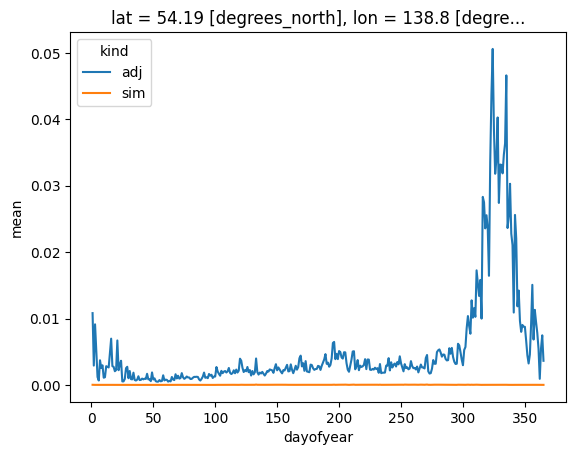

In [33]:
ds.sel(lat=bad_lat, lon=bad_lon)["mean"].plot(x="dayofyear", hue="kind")

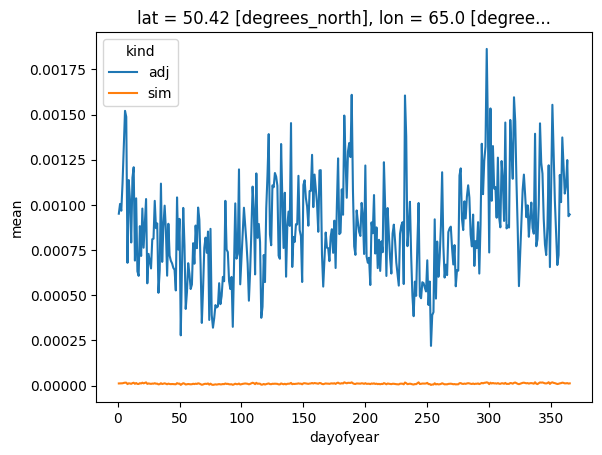

In [39]:
ds.sel(lat=-147, lon=65, method="nearest")["mean"].plot(x="dayofyear", hue="kind")

In [4]:

for version in ["sim", "adj"]:
    fp = f"{doy_summary_dir}/{combo_string}_{version}.nc"
    ds = xr.open_dataset(fp).squeeze()

    # Convert the Kelvin values to Fahrenheit to make plots more intuitive.
    ds = (ds - 273.15) * 9 / 5 + 32

    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    stats = ["min", "mean", "max"]
    for idx in range(3):
        print(f"{version} min/mean/max")
        mins = ds[stats[idx]].min(dim="lat").min(dim="lon")
        means = ds[stats[idx]].mean(dim="lat").mean(dim="lon")
        maxes = ds[stats[idx]].max(dim="lat").max(dim="lon")

        maxes.plot(label="Max", ax=axs[idx])
        means.plot(label="Mean", ax=axs[idx])
        mins.plot(label="Min", ax=axs[idx])

        axs[idx].set_title(f"{version}: tasmax ({stats[idx]})", fontweight="bold", size=20)
        axs[idx].set_xlabel("Day of Year", size=20)
        axs[idx].set_ylabel("Temperature (°F)", size=20)
        plt.legend()

    plt.subplots_adjust(top=0.93, bottom=0.07, left=0.05, right=0.95)
    plt.show()


In [7]:
sim_fps, adj_fps = get_sim_fps(model, scenario, var_id, model_years)

In [9]:
np.sum([fp.stat().st_size for fp in sim_fps]) / 1024**3

1.4511713758111

In [5]:
def open_and_extract_stats(fps, var_id):
    with xr.open_mfdataset(fps) as ds:
        doy_da = ds[var_id].groupby("time.dayofyear")
        stat_ds = xr.merge(
            [
                doy_da.min().rename("min"),
                doy_da.mean().rename("mean"),
                doy_da.max().rename("max"),
            ]
        ).compute()

    del ds

    return stat_ds

In [6]:
@dask.delayed
def open_and_extract_stats(fps, var_id):
    with xr.open_mfdataset(fps) as ds:
        doy_da = ds[var_id].groupby("time.dayofyear")
        stat_ds = xr.merge(
            [
                doy_da.min().rename("min"),
                doy_da.mean().rename("mean"),
                doy_da.max().rename("max"),
            ]
        )

    return stat_ds

In [7]:
def add_dims(ds, kind, scenario, var_id, model):
    return ds.assign_coords(
        kind=kind, scenario=scenario, var_id=var_id, model=model
    ).expand_dims(["kind", "scenario", "var_id", "model"])

In [32]:
@dask.delayed
def open_and_extract_stats(fps, var_id):
    try:
        with xr.open_mfdataset(fps) as ds:
            doy_da = ds[var_id].groupby("time.dayofyear")
            stat_ds = xr.merge(
                [
                    doy_da.min().rename("min"),
                    doy_da.mean().rename("mean"),
                    doy_da.max().rename("max"),
                ]
            )
    except:
        print(fps[0], "FAILED")
        with xr.open_mfdataset(fps) as ds:
            stat_ds = ds[var_id]

    return stat_ds


def add_dims(ds, kind, scenario, var_id, model):
    return ds.assign_coords(
        kind=kind, scenario=scenario, var_id=var_id, model=model
    ).expand_dims(["kind", "scenario", "var_id", "model"])

ds_list = []

sim_fps, adj_fps = get_sim_fps(model, scenario, var_id, model_years)
if len(adj_fps) == 0:
    print("No adjusted data found for ", model, scenario, var_id)

sim_ds = open_and_extract_stats(sim_fps, var_id)
sim_ds = add_dims(
    sim_ds,
    kind="sim",
    scenario=scenario,
    var_id=var_id,
    model=model,
)
ds_list.append(sim_ds)
print("sim_ds", scenario, "done")

adj_ds = open_and_extract_stats(adj_fps, var_id)
adj_ds = add_dims(
    adj_ds,
    kind="adj",
    scenario=scenario,
    var_id=var_id,
    model=model,
)
ds_list.append(adj_ds)
print("adj_ds", scenario, "done")

hist_sim_ds
hist_adj_ds
proj_sim_ds ssp126 done
proj_adj_ds ssp126 done
proj_sim_ds ssp245 done
proj_adj_ds ssp245 done
proj_sim_ds ssp370 done
proj_adj_ds ssp370 done
proj_sim_ds ssp585 done
proj_adj_ds ssp585 done
hist_sim_ds
hist_adj_ds
proj_sim_ds ssp126 done
proj_adj_ds ssp126 done
proj_sim_ds ssp245 done
proj_adj_ds ssp245 done
proj_sim_ds ssp370 done
proj_adj_ds ssp370 done
proj_sim_ds ssp585 done
proj_adj_ds ssp585 done
hist_sim_ds
hist_adj_ds
proj_sim_ds ssp126 done
proj_adj_ds ssp126 done
proj_sim_ds ssp245 done
proj_adj_ds ssp245 done
proj_sim_ds ssp370 done
proj_adj_ds ssp370 done
proj_sim_ds ssp585 done
proj_adj_ds ssp585 done
No adjusted data found for  EC-Earth3-Veg ssp585 pr
No adjusted data found for  EC-Earth3-Veg ssp585 tasmin
No adjusted data found for  EC-Earth3-Veg ssp585 tasmax
hist_sim_ds
hist_adj_ds
proj_sim_ds ssp126 done
proj_adj_ds ssp126 done
proj_sim_ds ssp245 done
proj_adj_ds ssp245 done
proj_sim_ds ssp370 done
proj_adj_ds ssp370 done
proj_sim_ds ssp585 d

In [33]:
results = dask.compute(ds_list, scheduler="synchronous")

In [46]:
results[0][0]["min"].load()

<xarray.DataArray 'min' (kind: 1, scenario: 1, var_id: 1, model: 1,
                         dayofyear: 365, lat: 43, lon: 288)>
array([[[[[[[1.3047047e-18, 1.3953579e-09, 1.3953579e-09, ...,
             1.3047047e-18, 1.3047047e-18, 1.3047047e-18],
            [4.1748579e-12, 2.5500941e-09, 2.5494329e-09, ...,
             3.5486281e-11, 9.8392416e-10, 1.3224801e-12],
            [6.2993048e-11, 1.2364773e-09, 1.2260123e-09, ...,
             5.3544091e-10, 1.5571835e-08, 2.0929888e-11],
            ...,
            [1.5063723e-07, 1.4714249e-07, 1.4617051e-07, ...,
             1.6299354e-07, 1.5724265e-07, 1.5312172e-07],
            [1.5460715e-07, 1.5445275e-07, 1.5455521e-07, ...,
             1.5472241e-07, 1.5467047e-07, 1.5463205e-07],
            [1.6061101e-07, 1.6061101e-07, 1.6061101e-07, ...,
             1.6061101e-07, 1.6061101e-07, 1.6061101e-07]],

           [[3.7432674e-08, 3.1305309e-08, 2.3331205e-08, ...,
             6.3635035e-08, 3.0690038e-07, 1.3177603e-07],
            [7.2096612e-10, 2.2739872e-08, 4.1232584e-10, ...,
             8.2686880e-10, 2.9356947e-10, 2.4941019e-10],
            [1.0058354e-08, 1.1220520e-08, 1.9664435e-10, ...,
             2.6355280e-09, 9.0630037e-10, 3.3718892e-09],
...
             4.5792891e-08, 3.3984616e-08, 3.6714749e-08],
            [6.4525225e-09, 6.3500520e-09, 6.4140928e-09, ...,
             6.2988494e-09, 6.2988197e-09, 6.3500520e-09],
            [6.5489680e-09, 6.5489680e-09, 6.5489680e-09, ...,
             6.5489680e-09, 6.5489680e-09, 6.5489680e-09]],

           [[3.9617795e-10, 4.6903985e-08, 4.6789697e-08, ...,
             2.4672323e-08, 4.4761012e-07, 5.3745117e-07],
            [1.4458250e-18, 1.4458250e-18, 4.0004985e-11, ...,
             1.5157420e-18, 4.7606402e-10, 6.8262747e-09],
            [1.4458250e-18, 1.4458250e-18, 6.3312905e-10, ...,
             1.5157446e-18, 7.5343110e-09, 3.9854534e-08],
            ...,
            [2.0548903e-07, 2.0455357e-07, 1.8569199e-07, ...,
             1.7680635e-07, 2.0440682e-07, 2.0550449e-07],
            [1.4591089e-07, 1.3638412e-07, 1.3666589e-07, ...,
             1.7544870e-07, 1.7106737e-07, 1.5495476e-07],
            [7.9079349e-08, 7.9079349e-08, 7.9079349e-08, ...,
             7.9079349e-08, 7.9079349e-08, 7.9079349e-08]]]]]]],
      dtype=float32)
Coordinates:
  * lat        (lat) float64 50.42 51.36 52.3 53.25 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * kind       (kind) <U3 'sim'
  * scenario   (scenario) <U10 'historical'
  * var_id     (var_id) <U2 'pr'
  * model      (model) <U13 'MPI-ESM1-2-LR'
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    original_name:  pr
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-09-04T14:41:51Z altered by CMOR: replaced missing va...
    grid_mapping:   spatial_ref

In [41]:
# xr.merge(results[0]).to_netcdf("ba_corpus_doy_summaries_.nc")

done


/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 5.69 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2024-04-30 08:13:18,643 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/msgpack/__init__.py", line 36, in packb
    return Packer(**kwargs).pack(o)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer

CancelledError: ('all-aggregate-afc542d08eee5c198fe0c6b4146451ff',)

In [17]:
sim_fps, adj_fps = get_sim_fps(model, scenario, var_id, model_years)

In [24]:
ds_list.append(open_and_extract_stats(sim_fps, var_id))

In [39]:
# "tas" in ERA5 is t2m, so we have named the daily max version t2mmax
# TODO: Handle all possible variables properly here.
if var_id == "tasmax":
    ref_var_id = "t2mmax"
else:
    ref_var_id = var_id

ref_fps = [
    ref_dir.joinpath(ref_var_id).joinpath(
        ref_tmp_fn.format(ref_var_id=ref_var_id, year=year)
    )
    for year in ref_years
]

PosixPath('/import/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid')

In [3]:
client = Client(n_workers=4, memory_limit="8GB")

distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-fwejdqe2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-faqr9pry', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-g2c_bkov', purging
distributed.diskutils - INFO - Found stale lock file and directory '/import/home/kmredilla/repos/cmip6-utils/bias_adjust/dask-worker-space/worker-y9tsiqex', purging


We will do this visually by just plotting time series for a few locations. 

We can compare this numerically for the whole datasets by using some distance metric like RMSE on the day-of-year means. We would assume the RMSE between adjusted-modeled and ERA5 reference is less than the biased-modeled and ERA5 reference.

We will just check both of these things at the same time for efficient data access.

In [11]:
def get_fps(model, scenario, var_id):
    ref_var_id = sim_ref_var_lu[var_id]
    ref_fps = [
        ref_dir.joinpath(ref_var_id, ref_tmp_fn.format(ref_var_id=ref_var_id, year=year))
        for year in ref_years
    ]

    sim_ref_fps = [
        generate_cmip6_fp(sim_dir, model, scenario, var_id, year, adjusted=False)
        for year in model_years
    ]

    adj_fps = list(adj_dir.joinpath(model, scenario, "day", var_id).glob("*.nc"))

    return ref_fps, sim_ref_fps, adj_fps


def plot_single_pixel_mean_doy(
    model,
    scenario,
    var_id,
):

    ref_fps, sim_ref_fps, adj_fps = get_fps(model, scenario, var_id)

    adj_ds = xr.open_mfdataset(adj_fps)
    ref_ds = xr.open_mfdataset(ref_fps)
    sim_ref_ds = xr.open_mfdataset(sim_ref_fps)

    ref_var_id = sim_ref_var_lu[var_id]

    # get doy means
    ref_doy_mean = ref_ds[ref_var_id].groupby("time.dayofyear").mean()
    simref_doy_mean = sim_ref_ds[var_id].groupby("time.dayofyear").mean()
    adj_doy_mean = (
        adj_ds[var_id]
        .sel(time=slice(str(model_years[0]), str(model_years[-1])))
        .groupby("time.dayofyear")
        .mean()
    )

    # Throw out all the pixels in adj_doy_mean that are between -180.0 and 0 degrees.
    adj_doy_mean = adj_doy_mean.where((adj_doy_mean.lon >= 0) & (adj_doy_mean.lon <= 360), drop=True)

    # pick a random pixel within the domain
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))


    for ax in axs.flatten():
        # lat = np.random.choice(ref_ds.lat.values)
        # lon = np.random.choice(ref_ds.lon.values)
        lon = np.random.uniform(35, 45)
        lat = np.random.uniform(55, 65)

        sel_di = dict(lat=lat, lon=lon)

        ref_doy_mean.sel(sel_di, method='nearest').plot(label="Reference", ax=ax)
        print("ref_doy_mean done")
        simref_doy_mean.sel(sel_di, method='nearest').plot(label="Model - biased", ax=ax)
        print("simref_doy_mean done")
        adj_doy_mean.sel(sel_di, method='nearest').plot(label="Model - adjusted", ax=ax, linestyle="--")
        print("adj_doy_mean done") 

    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


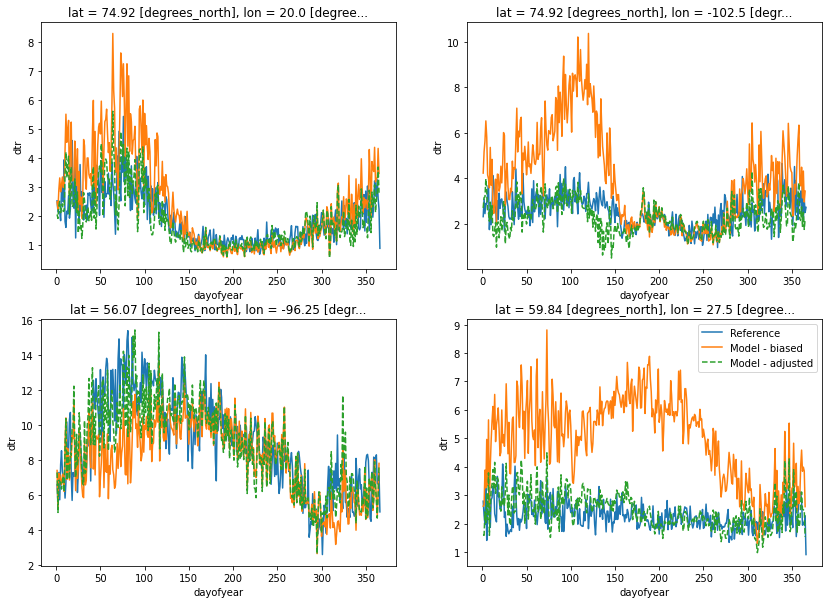

In [12]:
plot_single_pixel_mean_doy(model, scenario, var_id)